In [1]:
#data loading
import pandas as pd

predata = pd.read_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Transfers/Datasets/2transfers_rund-7M.csv')

In [2]:
#imbalance of the dataset
predata['is_fraud'].value_counts()

0    7000000
1        569
Name: is_fraud, dtype: int64

In [3]:
#initial number of columns and rows of the dataframe
predata.shape

(7000569, 19)

In [5]:
#visualize the whole output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
#ignore warnings from ctgan
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [9]:
#change data types for columns that need to be categorical
convert_dict = {'clientid': object, 'entity': object, 'reference': object, 'iban_orig': object, 'iban_dest': object, 
                'hour': object, 'week': object, 'weekday': object, 'month': object}

predata = predata.astype(convert_dict)

In [13]:
#generate synthetic frauds  
from sdv.tabular import CTGAN

model = CTGAN(epochs = 100, verbose = True) 

model.fit(predata) 

AttributeError: 'bool' object has no attribute 'astype'

In [5]:
#number of frauds to generate 
f = len(predata[(predata['is_fraud'] == 0)]) - len(predata[(predata['is_fraud'] == 1)])

In [6]:
#conditional sampling
from sdv.sampling import Condition

#generate only values that satisfy this condition
condition = Condition({'is_fraud': 1}, num_rows = f)

#generate synthetic data
frauds_data = model.sample_conditions(conditions = [condition])

Sampling conditions: 100%|█████████████████████████████████████████████████████████| 6543/6543 [02:07<00:00, 51.34it/s]


In [7]:
#create the new dataframe
predatabalanced = pd.concat([predata, frauds_data], ignore_index = True) 

In [8]:
#make sure the dataset is now balanced
predatabalanced['is_fraud'].value_counts()

0    7112
1    7112
Name: is_fraud, dtype: int64

In [9]:
#comparision of the shape of the actual data and the generated data
from table_evaluator import load_data, TableEvaluator

predata.shape, predatabalanced.shape

((7681, 19), (14224, 19))

In [19]:
#evaluate the synthetic data
from sdv.evaluation import evaluate

#separate scores 
evaluate(predatabalanced, predata, metrics = ['CSTest', 'KSTest', 'GMLogLikelihood'], aggregate = False)

#CSTest - chi-2 test to compare the distributions of the discrete (categorical/boolean) columns returns the average of the 
#p-values obtained across all the columns
#KSTest - 2 sample kolmogorov–smirnov test to compare the distributions of numerical columns using the empirical CDF returns 
#the average of the KS statistic values obtained across all the columns
#GMLogLikelihood - fits GMM to the real data and evaluates how likely the synthetic data belongs to the same distribution as 
#the real data

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.988550,9.885504e-01,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.893692,8.936918e-01,0.0,1.0,MAXIMIZE,None
2,GMLogLikelihood,GaussianMixture Log Likelihood,-65.479951,3.651057e-29,-inf,inf,MAXIMIZE,None


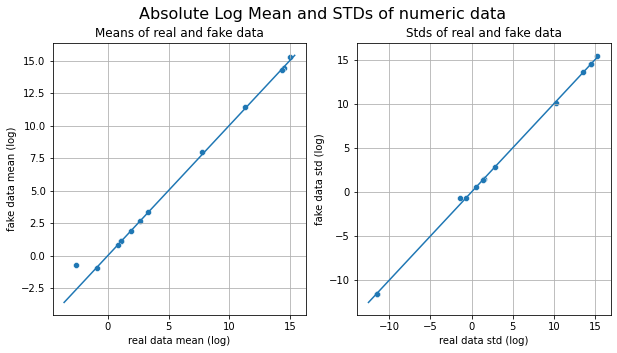

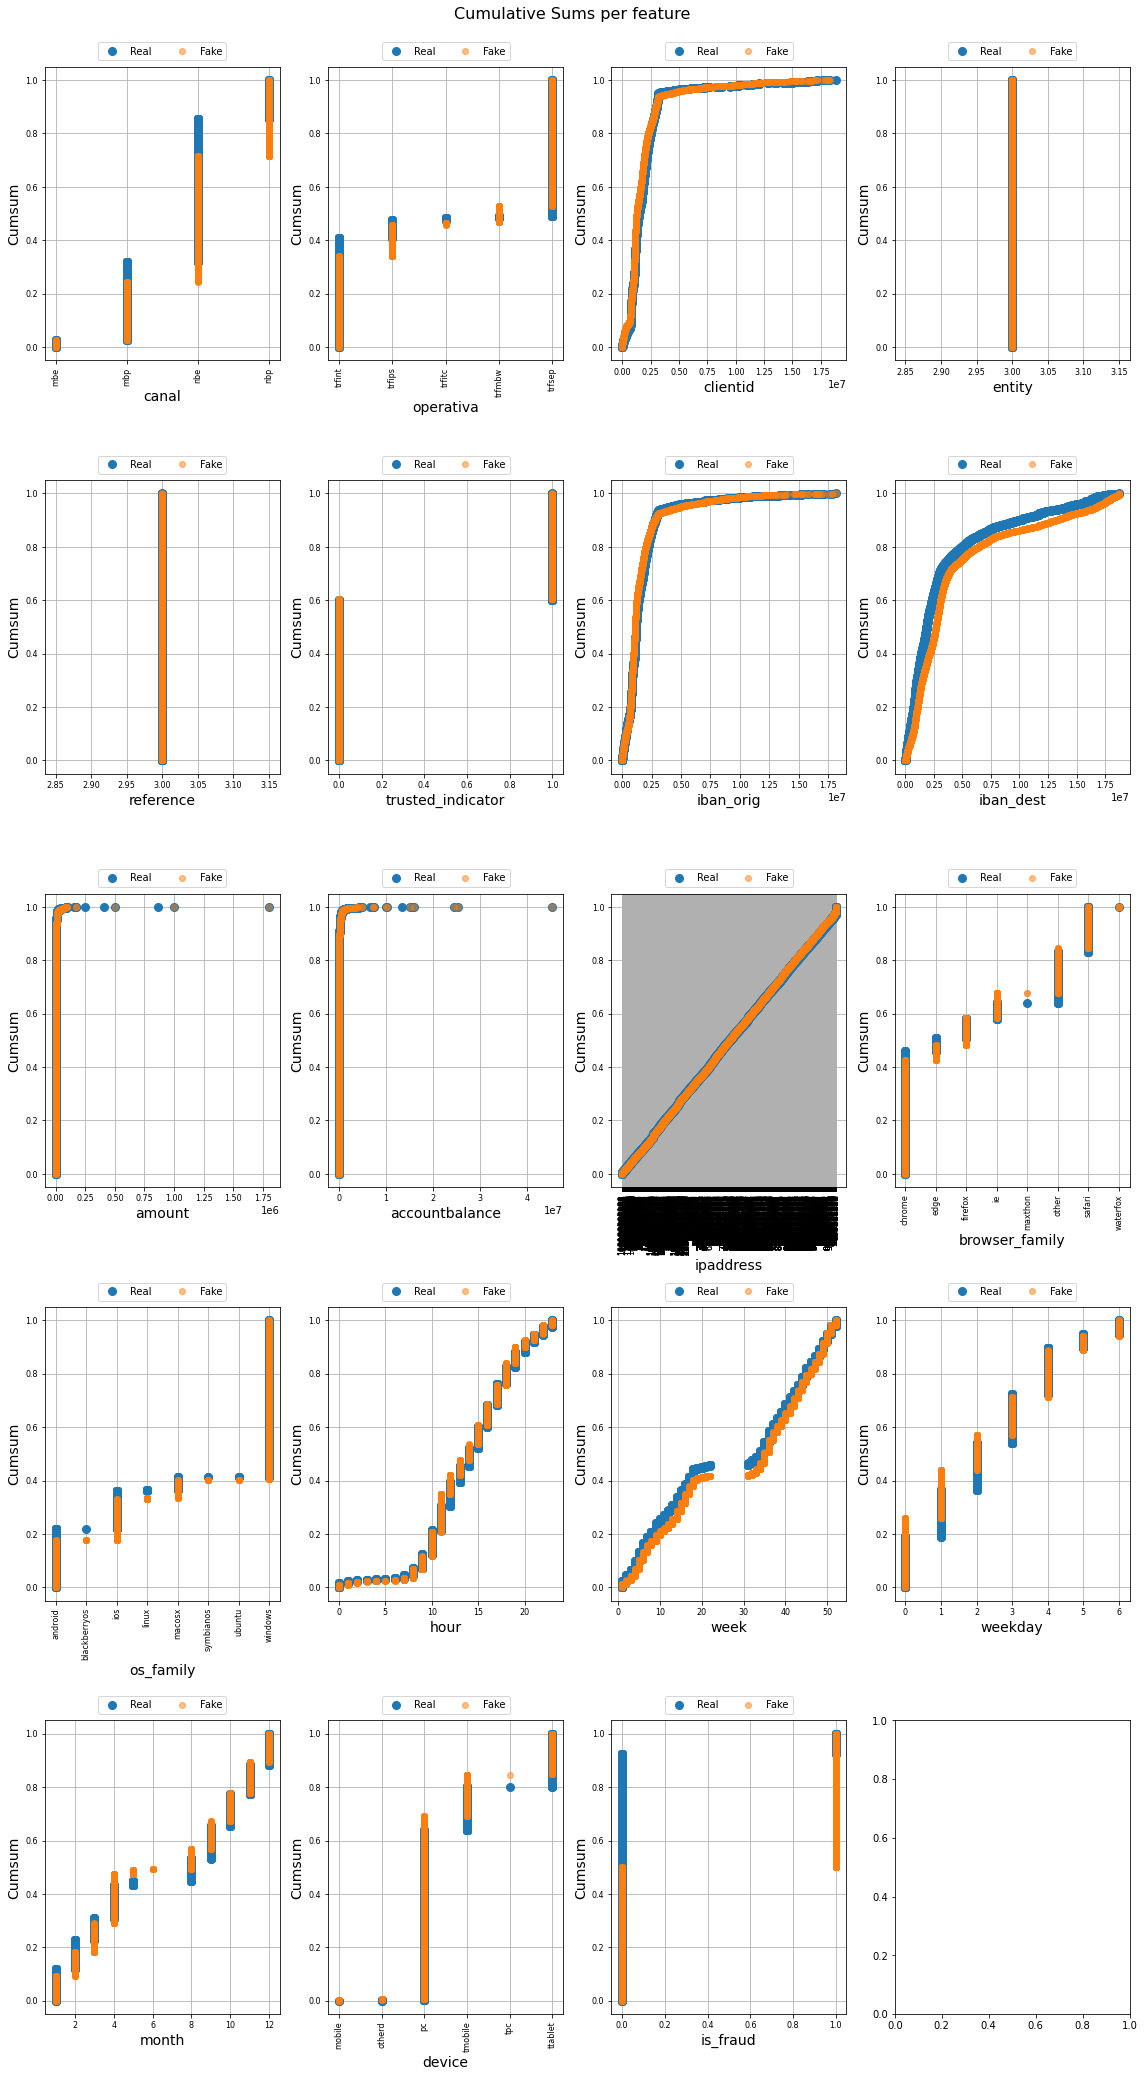

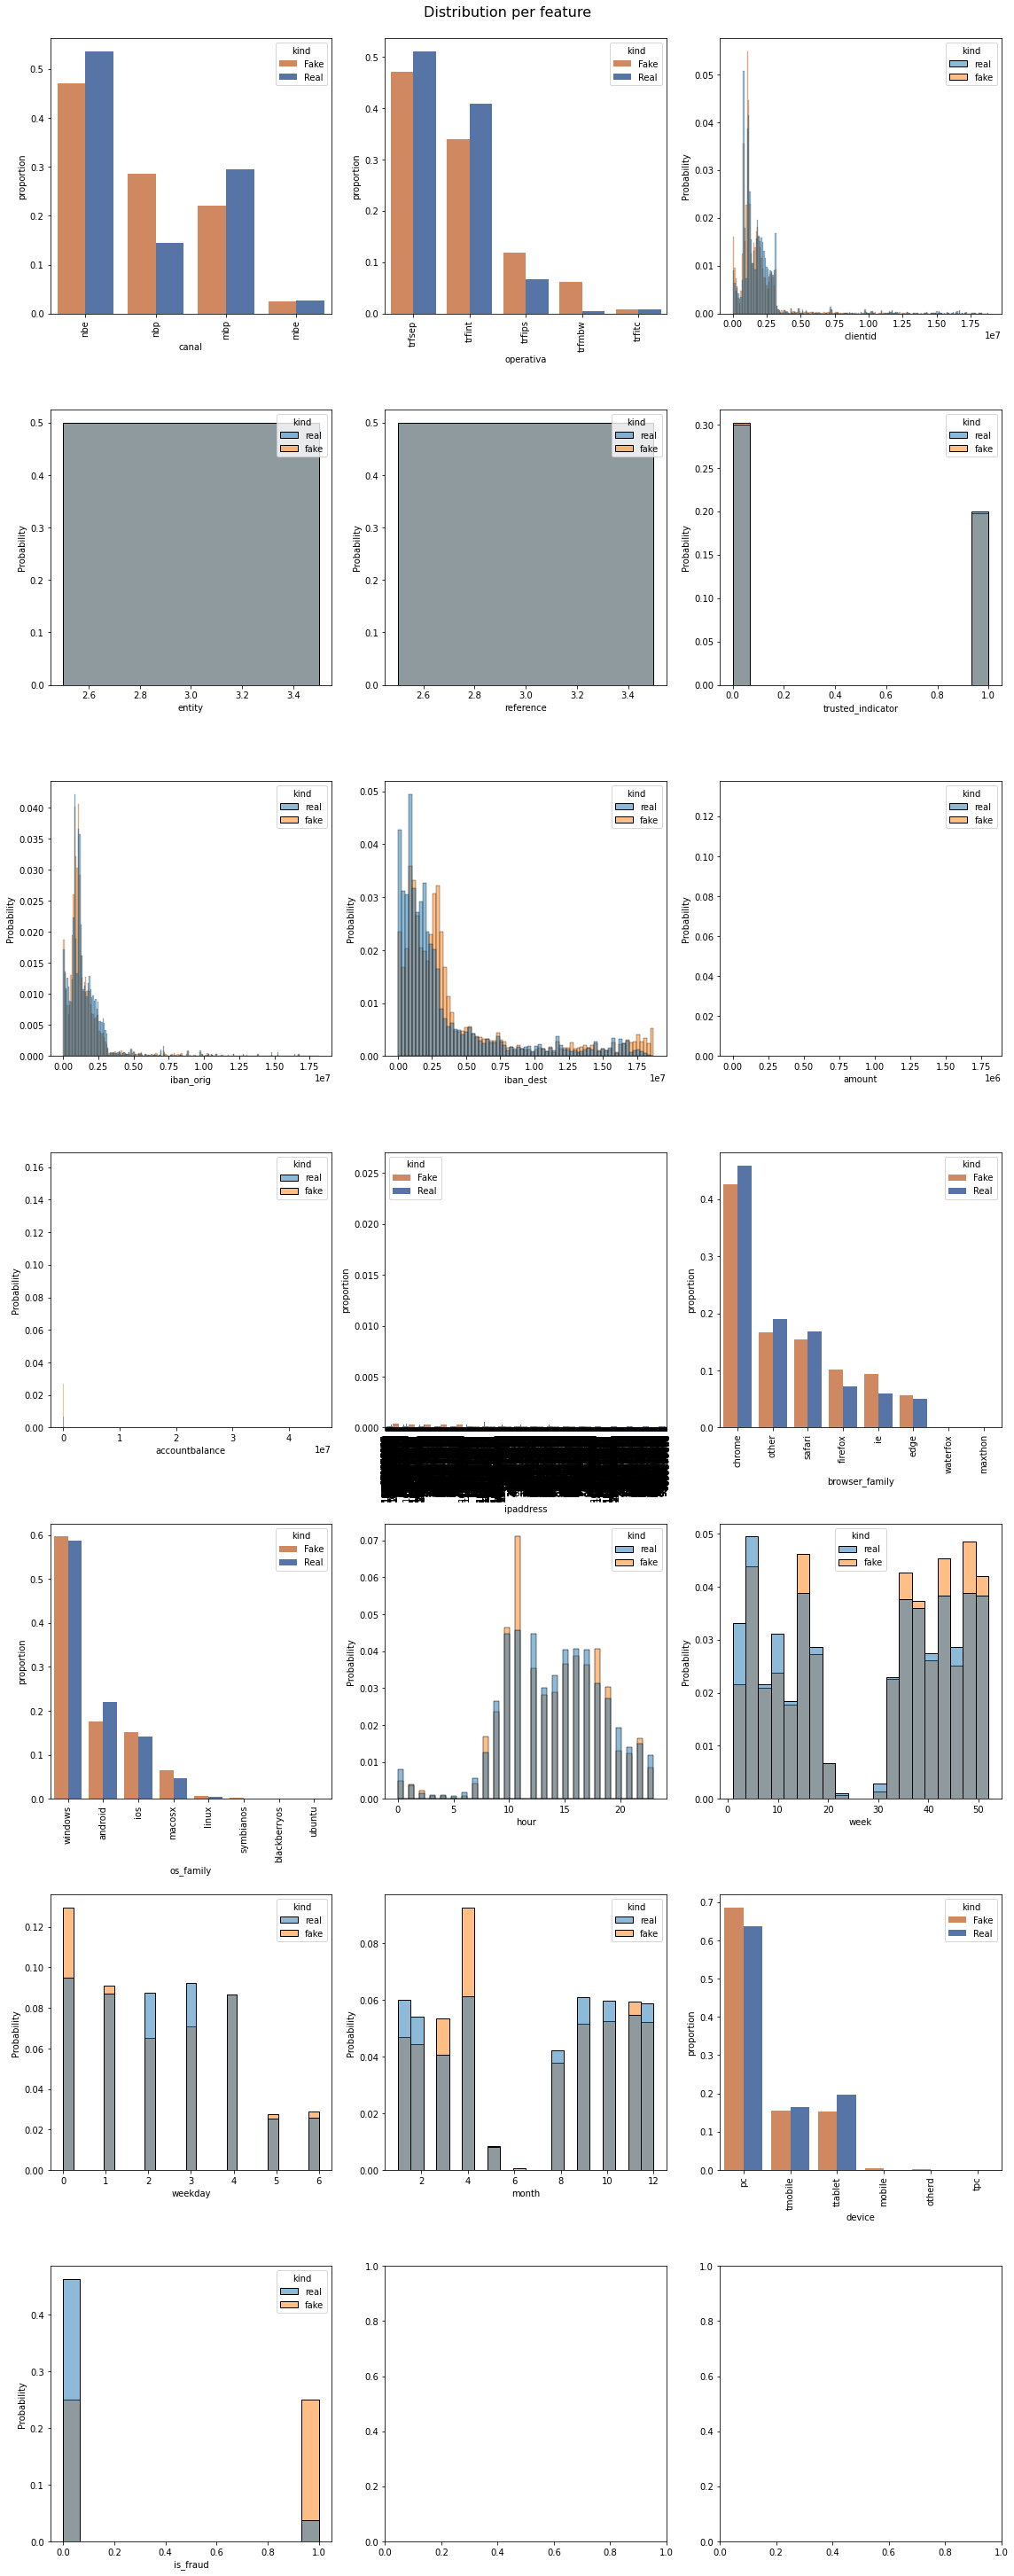

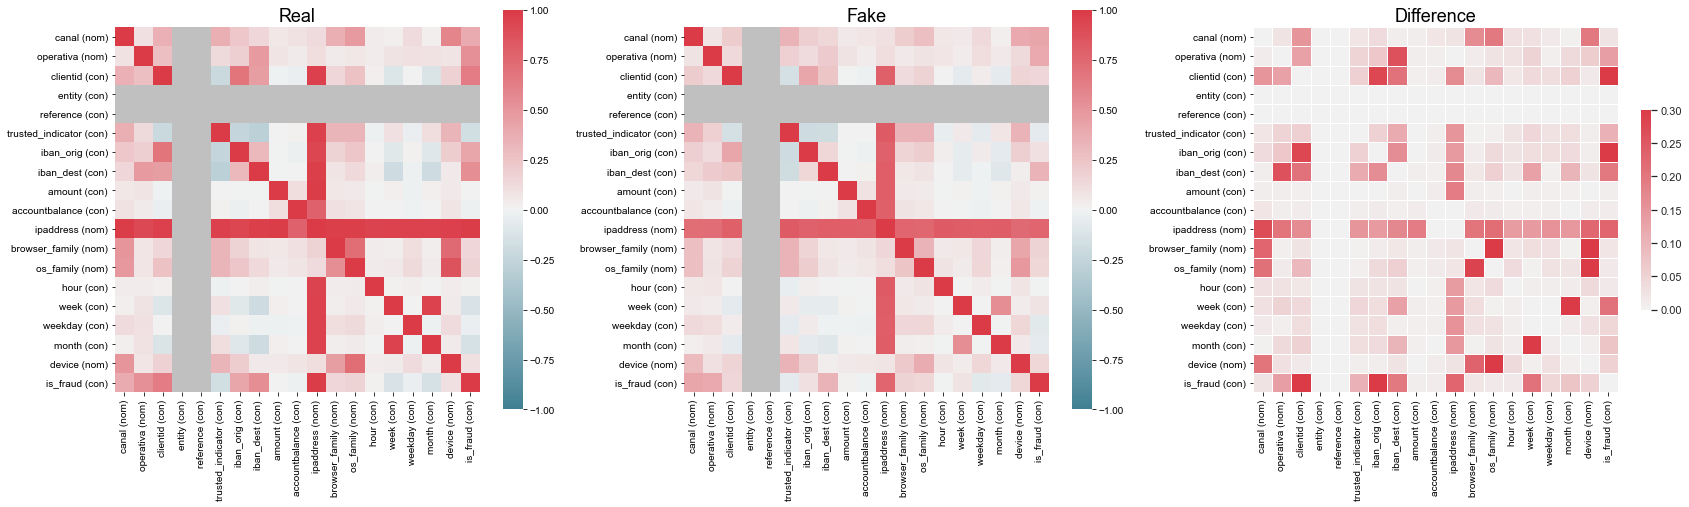

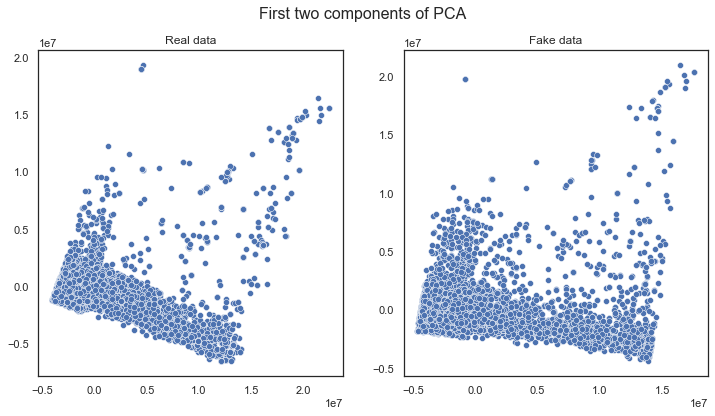

In [20]:
#evaluate how similar the two dataframes are by graphics 
table_evaluator =  TableEvaluator(predata, predatabalanced) 

table_evaluator.visual_evaluation()

In [ ]:
#save the balanced dataset
predatabalanced.to_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Datasets/2transfers_balanced_gan+rund.csv', index = False)

In [ ]:
#profiling of the data
from pandas_profiling import ProfileReport

#ProfileReport(predata.sample(n = 10000)) for randomize data order and select representative sample
prof = ProfileReport(predatabalanced, minimal = True)             
prof.to_file(output_file = '2transfers_balanced_gan+rund.html')

In [ ]:
#select all transfers frauds after balance and save in a csv file
#transfers frauds
target_col = 'is_fraud'
frauds_transfers = predatabalanced[(predatabalanced[target_col] == 1)].copy()

#save csv file
frauds_transfers.to_csv(r'C:/Users/BeatrizCarvalho/OneDrive - Closer Consultoria Lda/Documents/Entangled-Spaces/Datasets/2frauds_transfers_balanced_gan+rund.csv', index = False)